\#Modern AI Pro: Document analysis with LLMs
### Step 1: Setup the basics for processing document:
Get one of our [research papers](https://drive.google.com/file/d/1kfjF9iuGG74ORFGu4v9dMO15pgsKI5Rh/view?usp=sharing) for sample. Download a copy locally and upload to the runtime.

In [ ]:
# We will use a simple utility to make the text wrap properly when printing.
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# Read pages of the document
!pip install -q -U pypdf2
from PyPDF2 import PdfReader
reader = PdfReader('arso.pdf')
text = ""
for i in range(0, len(reader.pages)):
    page = reader.pages[i]
    text += page.extract_text() + " "

In [ ]:
def display_word_cloud(top_100_words):
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_100_words))

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

## Step 2: Visualize the data

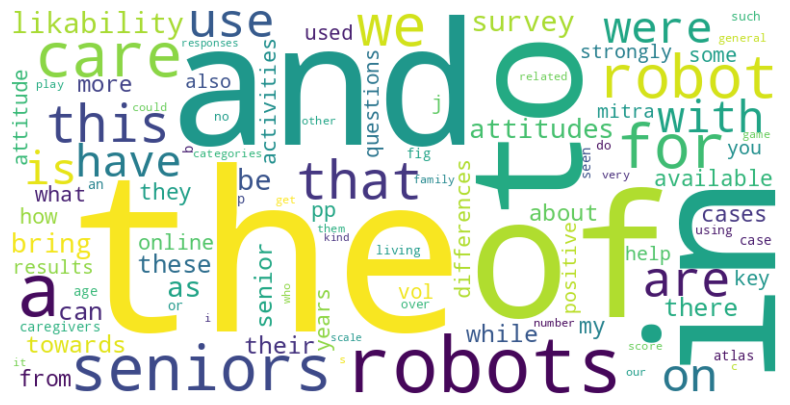

In [ ]:
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = re.sub(r'[^a-zA-Z\s]', '', text)
text = text.lower()
words = text.split()
word_counts = Counter(words)
top_100_words = word_counts.most_common(100)

display_word_cloud(top_100_words)

That is a lot of just common words. Let's remove them and display again.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


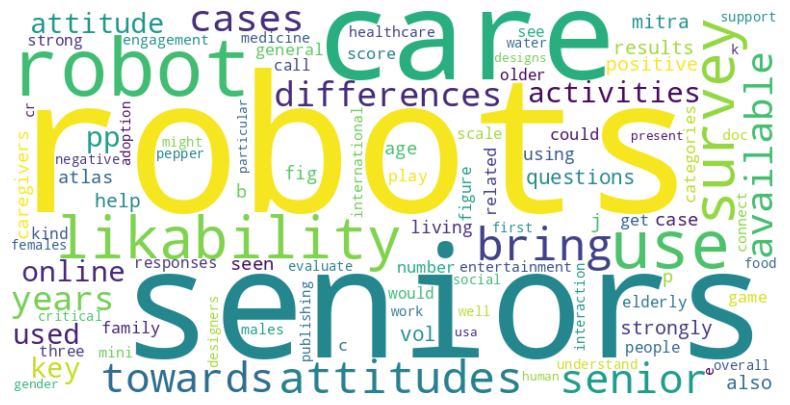

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Filter out stop words from your list of words
filtered_words = [word for word in words if word not in stop_words]
word_counts_filtered = Counter(filtered_words)

# If you still want to limit it to the top 100 words
top_100_words_filtered = word_counts_filtered.most_common(100)

display_word_cloud(top_100_words_filtered)

Lemmatize to group similar words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


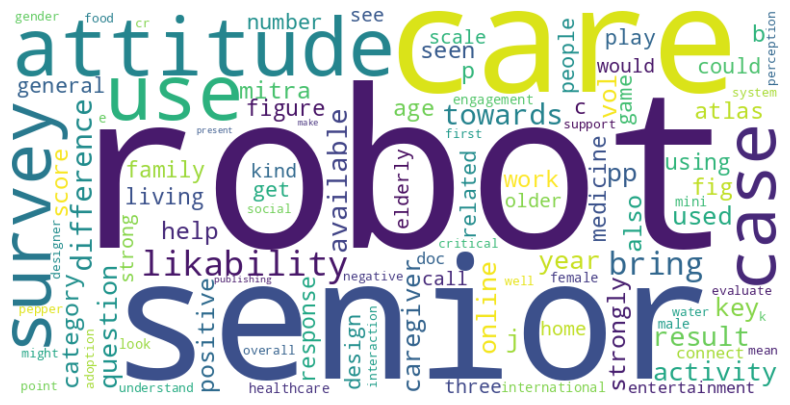

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
tokens = word_tokenize(text)  # Tokenize the text
stop_words = set(stopwords.words('english'))

# Lemmatize tokens and remove stop words
lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalpha()]

# Recount words
word_counts = Counter(lemmatized_tokens)

# Extract the top 100 words
top_100_words_lemmatized = word_counts.most_common(100)
display_word_cloud(top_100_words_lemmatized)

## Step 3: Storing the docs in Vector DB

**Split the texts into small chunks**

In [ ]:
!pip install -q -U langchain langchainhub langchain-community chromadb sentence-transformers
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema.document import Document

documents = [Document(page_content=text, metadata={"source": "local"})]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=40)
all_splits = text_splitter.split_documents(documents)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.2/806.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.4/252.4 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2", model_kwargs={"device": "cpu"})

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from langchain.vectorstores import Chroma

vectordb_paper = Chroma.from_documents(documents=all_splits, embedding=embeddings, persist_directory="chroma_db_paper")
retriever_paper = vectordb_paper.as_retriever()

## Step 3: Setting up the LLM

In [ ]:
from google.colab import userdata

!pip install git+https://gitlab.com/gauthammsam/mitrallm.git --quiet
from mitrallm import MitraLLM
llm = MitraLLM(
    token     = userdata.get("MITRA_TOKEN"),
    accessapi = userdata.get("MITRA_ENDPOINT")
)
print(llm)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.0/817.0 kB 6.3 MB/s eta 0:00:00
MitraLLM
Params: {'URL': 'https://mitrallm.mitrarobot.com'}


In [ ]:
from langchain.chains import RetrievalQA
qa_paper = RetrievalQA.from_chain_type(
    llm,
    chain_type="stuff",
    retriever=retriever_paper,
    verbose=True
)

In [ ]:
def rag_manager(qa, query):
    print("\nResult: ", qa.run(query))

In [ ]:
rag_manager(qa_paper,"Tell me about the likability index")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new RetrievalQA chain...

> Finished chain.

Result:  The likability index appears to be a tool or metric that has been used to evaluate a range of robots based on how they are perceived by end-users. Its purpose is to understand how people, especially in this context seniors living in senior homes, respond to different robots in terms of likability. This index seems to measure various positive categories to assess acceptance and appeal of robots to those who interact with them. Presentations of the likability index have been conducted and it has been used to survey people, with the results indicating above-average scores in the positive categories. This suggests that robots are generally well-received among the surveyed group, providing valuable feedback to designers who aim to create robots that are better accepted by users, particularly the elderly. Figures referenced, such as "fig likability of various robots" and "fig age differences in attitudes toward specific activ

## Step 4: You can analyze any piece of text now.

In [ ]:
news = """SRINAGAR, India (AP) — For decades, India has focused its defense policy on its land borders with rivals Pakistan and China. Now, as its global ambitions expand, it is beginning to flex its naval power in international waters, including anti-piracy patrols and a widely publicized deployment close to the Red Sea to help protect ships from attacks during Israel’s war with Hamas.

India sent three guided missile destroyers and reconnaissance aircraft in November when Yemen-based Houthi rebels began targeting ships in solidarity with Hamas, causing disruptions in a key trading route that handles about 12% of global trade.

The deployment highlights the country as a “proactive contributor” to international maritime stability, said Vice Adm. Anil Kumar Chawla, who retired in 2021 as head of India’s southern naval command.


“We are not doing it only out of altruism. Unless you are a maritime power you can never aspire to be a global power,” Chawla said. India, already a regional power, is positioning itself “as a global player today, an upcoming global power,” he said.
India is widely publicizing the deployments, signaling its desire to assume a wider responsibility in maritime security to the world and its growing maritime ambitions to regional rival China.

“It is a message to China that, look, we can deploy such a large force here. This is our backyard. Though we don’t own it, but we are probably the most capable and responsible resident naval power,” Chawla said.

The Indian navy has helped at least four ships, three of which were attacked by Houthi rebels and another that Washington blamed on Iran, a charge denied by Tehran. It has also conducted several anti-piracy missions."""

documents = [Document(page_content=news, metadata={"source": "local"})]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=20)
all_splits = text_splitter.split_documents(documents)

In [ ]:
vectordb = Chroma.from_documents(documents=all_splits, embedding=embeddings, persist_directory="chroma_db")
retriever = vectordb.as_retriever()
qa = RetrievalQA.from_chain_type(
    llm= llm,
    chain_type="stuff",
    retriever=retriever,
    verbose=True
)

In [ ]:
rag_manager(qa, """ What are all the key countries involved in this? """)



> Entering new RetrievalQA chain...

> Finished chain.

Result:  The key countries involved in this context are:

1. India - deploying naval forces and conducting patrols.
2. Yemen - the location of Houthi rebels who are targeting ships.
3. Pakistan and China - mentioned as rivals with whom India has traditionally focused its defense policy on their land borders.
4. Israel - country involved in the conflict with Hamas.
5. United States - mentioned in reference to blaming Iran for an attack on a ship.
6. Iran - denies the charge from the United States about attacking a ship.
